In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = "customer_booking.csv"

In [3]:
import chardet

with open("customer_booking.csv", "rb") as f:
    result = chardet.detect(f.read(100000))
    
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [4]:
df = pd.read_csv(data, encoding='ISO-8859-1')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [8]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [9]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [10]:
df.booking_complete.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [11]:
X = df.drop("booking_complete", axis=1)
y = df.booking_complete

for col_name in X.select_dtypes('object'):
    X[col_name], _ = X[col_name].factorize()

In [12]:
X.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,2,0,0,262,19,7,0,0,0,1,0,0,5.52
1,1,0,0,112,20,3,0,0,0,0,0,0,5.52
2,2,0,0,243,22,17,1,0,1,1,1,0,5.52
3,1,0,0,96,31,4,0,0,0,0,0,1,5.52
4,2,0,0,68,22,15,1,0,1,1,0,1,5.52


In [13]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [14]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores

route                    0.052966
booking_origin           0.047560
flight_duration          0.018395
wants_extra_baggage      0.008646
length_of_stay           0.008005
num_passengers           0.005374
wants_in_flight_meals    0.004797
wants_preferred_seat     0.004150
flight_day               0.002298
flight_hour              0.001248
trip_type                0.000911
purchase_lead            0.000691
sales_channel            0.000493
Name: MI Scores, dtype: float64

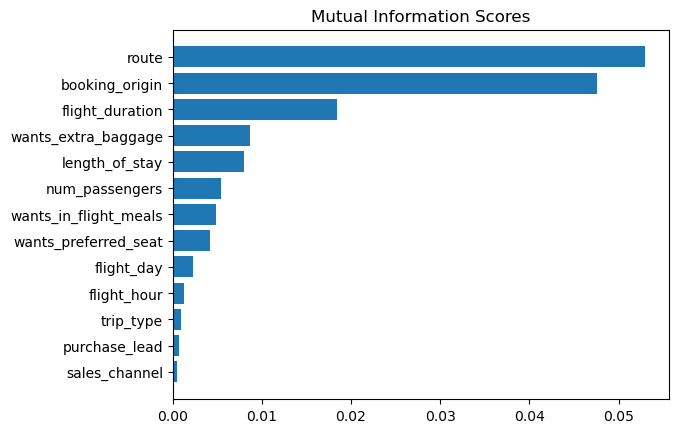

In [16]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores)

In [23]:
from sklearn.model_selection import train_test_split

def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)
    
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y , test_size=0.2, random_state=0)
    return train_X, val_X, train_y, val_y

In [25]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X)
    return scaled

## Model 1: Random Forest Classifier with top 6 features

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

features = ['route', 'booking_origin', 'flight_duration', 'wants_extra_baggage', 'length_of_stay', 'num_passengers']

X = df[features]
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
preds = model.predict(X_val)

print('Accuracy Score: ', accuracy_score(y_val, preds)*100)
print("AUC Score: ", roc_auc_score(y_val, preds))

Accuracy Score:  82.46
AUC Score:  0.5857342877575447


## Model 2: Random Forest Classifier with all features

In [41]:
X = df.drop("booking_complete", axis=1)
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
preds = model.predict(X_val)

def scores(y_val, preds):
    print("Accuracy score: ", accuracy_score(y_val, preds)*100)
    print("AUC Score: ", roc_auc_score(y_val, preds))

scores(y_val, preds)

Accuracy score:  84.95
AUC Score:  0.5528815463734396


## Model 3: XGB classifier with top 6 features

In [45]:
from xgboost import XGBClassifier

X = df[features]
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

model = XGBClassifier()
model.fit(X_train, y_train)
xg_preds = model.predict(X_val)

scores(y_val, xg_preds)

Accuracy score:  84.7
AUC Score:  0.5201798076775561


## Model 4: XGB Classifier with all features

In [46]:
X = df.drop('booking_complete', axis=1)
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

model = XGBClassifier()
model.fit(X_train, y_train)
xg_preds = model.predict(X_val)

scores(y_val, xg_preds)

Accuracy score:  84.89999999999999
AUC Score:  0.5395523077906718


### Finalizing Random Forest Classifier with all features as final model
Validating with test data set

In [47]:
X = df.drop("booking_complete", axis=1)
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
preds = model.predict(X_test)

scores(y_test, preds)

Accuracy score:  85.08
AUC Score:  0.5579923137373275
